# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

# Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase : music recommender system

- Understand how to validate the results

# Steps

In particular, we guide students through the following steps, which constitute a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.

# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

The data we use in this Notebook is available in 3 files:

- **`user_artist_data.txt`**: It contains about 141,000 unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|-----|--------|---------|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
import os
import sys
import re
import random
import types 
import math

from pprint import pprint
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

from pyspark.ml.feature import PCA
#from pyspark.mllib.linalg import Vectors, VectorUDT
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
import numpy as np
from time import time

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0

Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [25]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) 

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()
userArtistDF.show(20)

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



<font color='blue'>
We also load data from ``/datasets/lastfm/artist_data.txt`` and ``/datasets/lastfm/artist_alias.txt`` that we will need later.
</font>

In [26]:
artistDataDataSchema = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDataDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_data.txt", schema = artistDataDataSchema) 

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistDataDF.cache()
artistDataDF = (artistDataDF.withColumn('artistID', artistDataDF.artistID.cast('int')))
artistDataDF.show()

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
|10186265|Jota Quest e Ivet...|
| 6828986|       Toto_XX (1977|
|10236364|         U.S Bombs -|
| 1135000|artist formaly kn...|
|10299728|Kassierer - Musik...|
|10299744|         Rahzel, RZA|
| 6864258|      Jon Richardson|
| 6878791|Young Fresh Fello...|
|10299751|          Ki-ya-Kiss|
| 6909716|Underminded - The...|
|10435121|             Kox-Box|
| 6918061|  alexisonfire [wo!]|
| 1135001|         dj salinger|
| 6940391|The B52's - Chann...|
|10475396|             44 Hoes|
+--------+--------------------+
only showing top 20 rows



In [6]:
artistName = artistDataDF.limit(30).collect()
names30 = [artistName[i][1] for i in range(len(artistName))]
pprint(names30)

['06Crazy Life',
 'Pang Nakarin',
 'Terfel, Bartoli- Mozart: Don',
 'The Flaming Sidebur',
 'Bodenstandig 3000',
 'Jota Quest e Ivete Sangalo',
 'Toto_XX (1977',
 'U.S Bombs -',
 'artist formaly know as Mat',
 'Kassierer - Musik für beide Ohren',
 'Rahzel, RZA',
 'Jon Richardson',
 'Young Fresh Fellowslows & the Minus 5',
 'Ki-ya-Kiss',
 'Underminded - The Task Of Modern Educator',
 'Kox-Box',
 'alexisonfire [wo!]',
 'dj salinger',
 "The B52's - Channel Z",
 '44 Hoes',
 'orchestral mandeuvres in dark',
 'Josh Groban (Featuring Angie Stone)',
 'Savage Garden - Truley, Madly, Deeply',
 'Nislije',
 'ONEYA BASSIVITYMIXTAPE',
 'Grant Green / Osunlade',
 'Jae Kwon',
 'Gwen vs. Britney',
 'Dj.DataStream & Al Fresco',
 'yaphet kotto - 02']


<font color='blue'> We immediately spot some problems here: our data is very dirty! Is there any misspelled or repeated name artist in the list? What happens when we have two or more artists for the same song? We will see the answers later.
</font>

In [27]:
artistAliasDataSchema = StructType([ \
    StructField("misspelledArtistID", LongType(), True), \
    StructField("standardArtistID", LongType(), True)])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t') \
    .load(base + "artist_alias.txt", schema = artistAliasDataSchema) 

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistAliasDF.cache()

artistAliasDF.show(5)

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
|           1092764|         1000311|
|           1095122|         1000557|
|           6708070|         1007267|
|          10088054|         1042317|
|           1195917|         1042317|
+------------------+----------------+
only showing top 5 rows



#### Question 1.1: 
How many distinct users in data ?

In [8]:
distinctUsers = userArtistDF.select('userID').distinct().count()
duplicateUsers = userArtistDF.select('userID').count()
print("Total n. of valid records for users: ", duplicateUsers)
print("Total n. of distinct users:          ", distinctUsers)

Total n. of valid records for users:  24296858
Total n. of distinct users:           148111


#### Question 1.2
How many distinct artists in data ?

In [9]:
distinctArtists = userArtistDF.select('ArtistID').distinct().count()
duplicateArtists = userArtistDF.select('ArtistID').count()
print("Total n. of valid records for artists: ", duplicateArtists)
print("Total n. of distinct artists:          ", distinctArtists)

Total n. of valid records for artists:  24296858
Total n. of distinct artists:           1631028


<font color='blue'> 
Let's dig a bit more on how the mapping of the artist IDs works: we have an artist named 'Gwen vs. Britney' which means two musicians are involved, hence they should both see an increment in their playcounts. What happens instead is that 'Gwen vs. Britney' is considered as a new single artist, which is wrong. We show this below.
</font>

In [10]:
artistDataDF[artistDataDF.name=='Gwen vs. Britney'].show()
artistDataDF[artistDataDF.name=='Britney Spears'].show()

+--------+----------------+
|artistID|            name|
+--------+----------------+
| 6953654|Gwen vs. Britney|
+--------+----------------+

+--------+--------------+
|artistID|          name|
+--------+--------------+
| 1291139|Britney Spears|
|    4163|Britney Spears|
+--------+--------------+



In [11]:
artistAliasDF[artistAliasDF.misspelledArtistID==6953654].show()
artistAliasDF[artistAliasDF.misspelledArtistID==1291139].show()
artistAliasDF[artistAliasDF.misspelledArtistID==4163].show()

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
+------------------+----------------+

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
|           1291139|            4163|
+------------------+----------------+

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
+------------------+----------------+



#### Question 1.3

One limitation of Spark MLlib's ALS implementation - which we will use later- is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than Integer.MAX_VALUE, or 2147483647, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.

What are the maximum and minimum values of column `userID` ?

HINT: Read section 4.3 of Lecture 2 again.

In [15]:
userArtistDF.select([min('userID'), max('userID')]).show()

+-----------+-----------+
|min(userID)|max(userID)|
+-----------+-----------+
|         90|    2443548|
+-----------+-----------+



In [16]:
tot = 0
nIter = 100
for i in range(nIter):
    t0 = time()
    maxID = userArtistDF.select([min('userID'), max('userID')])
    t1 = time()
    tot += t1-t0 
ave = tot/nIter
print("average time %f secs" % ave)
maxID.show()

average time 0.010444 secs
+-----------+-----------+
|min(userID)|max(userID)|
+-----------+-----------+
|         90|    2443548|
+-----------+-----------+



In [17]:
tot = 0
nIter = 100
for i in range(nIter):
    t0 = time()
    maxID = userArtistDF.orderBy('userID', ascending=0).take(1)
    minID = userArtistDF.orderBy('userID', ascending=1).take(1)
    t1 = time()
    tot += t1-t0 
ave = tot/nIter
print("average time %f secs" % ave)
print("max userID", maxID[0][0])
print("min userID", minID[0][0])

average time 0.702405 secs
max userID 2443548
min userID 90


In [18]:
userArtistDF2 = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) 
#    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF2.cache()
tot = 0
nIter = 100
for i in range(nIter):
    t0 = time()
    maxID = userArtistDF2.groupBy().max('userID').take(1)
    minID = userArtistDF2.groupBy().min('userID').take(1)
    t1 = time()
    tot += t1-t0 
ave = tot/nIter
print("average time %f secs" % ave)
print("max userID", maxID[0][0])
print("min userID", minID[0][0])

average time 0.298453 secs
max userID 2443548
min userID 90


<font color='blue'>
Above, we showed three possible ways to answer the question: the second requires sorting twice, the third requires two groupBy. The first approach is definitely the fastest and simplest. 
</font>

#### Question 1.4
What is the maximum and minimum values of column `artistID` ?

In [19]:
userArtistDF.select([min('artistID'), max('artistID')]).show()

+-------------+-------------+
|min(artistID)|max(artistID)|
+-------------+-------------+
|            1|     10794401|
+-------------+-------------+



We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides us many very concise and powerful tools to do data analytics (comparing to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
How many times each user has played a song? Show 5 samples of the result.

In [48]:
userActivity = userArtistDF.groupBy('userID').sum('playCount')
userActivity.show(5)
sortedUserActivity = userActivity.orderBy('sum(playCount)', ascending=0)
print('TOP 10 USERS BY ACTIVITY')
sortedUserActivity.show(10)

+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|1066825|             4|
|1068108|          4506|
|1070733|         14631|
|1070807|             3|
|1071739|          3279|
+-------+--------------+
only showing top 5 rows

TOP 10 USERS BY ACTIVITY
+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|1059637|        674412|
|2064012|        548427|
|2069337|        393515|
|2023977|        285978|
|1046559|        183972|
|1052461|        175822|
|1070932|        168977|
|1031009|        167273|
|2020513|        165642|
|2062243|        151504|
+-------+--------------+
only showing top 10 rows



In [9]:
sortedUserActivityPD = pd.DataFrame(data=sortedUserActivity.limit(10).collect())
users = sortedUserActivityPD[0].values
counts = sortedUserActivityPD[1].values

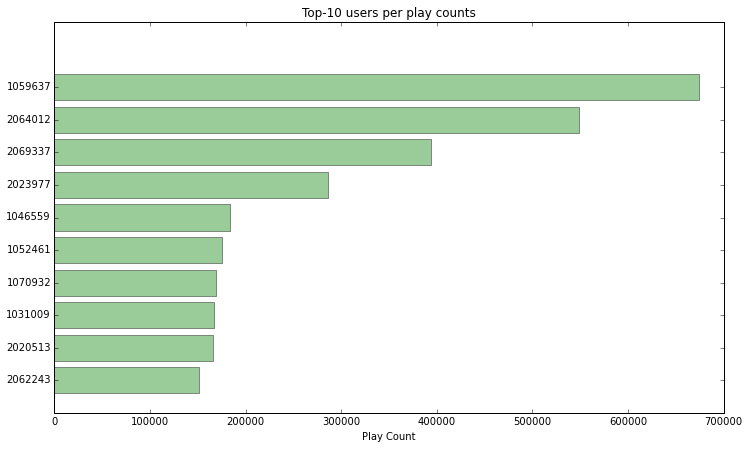

In [22]:
y_pos = np.arange(len(users))
plt.figure(figsize=(12,7))

plt.barh(y_pos, counts, align='center', alpha=0.4, color='green')
plt.yticks(y_pos, users)
plt.xlabel('Play Count')
plt.gca().invert_yaxis()
plt.title('Top-10 users per play counts')
plt.show()

#### Question 2.2
Plot CDF (or ECDF) of number of play counts per User ID.

Explain and comment the figure you just created: 

* for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible.
* discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system.
* look at outliers and reason about their impact on your reccommender algorithm

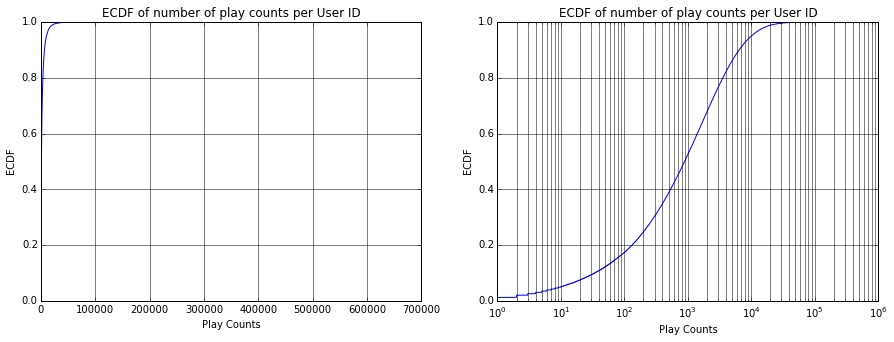

In [23]:
pdf = pd.DataFrame(data=userActivity.collect())
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')

plt.subplot(122)
plt.semilogx(Y, yvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')

plt.show()

<font color='blue'>
From the graph on the right (with log-scale), we can verify that just a few users played more than $5\times10^4$, which is in line with the previous results
</font>

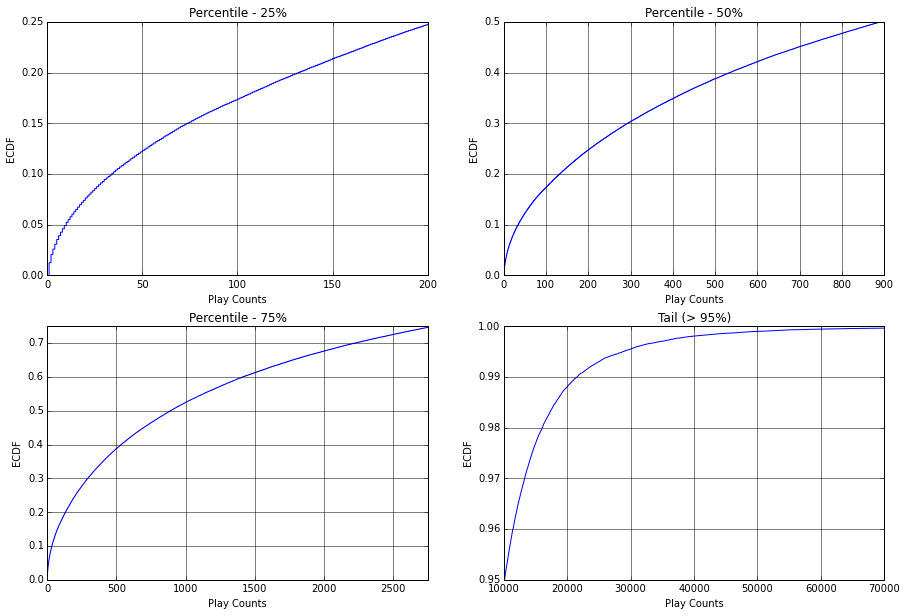

In [24]:
#pdf = pd.DataFrame(data=userActivity.filter(userActivity['sum(playCount)']<40000).collect())
pdf = pd.DataFrame(data=userActivity.collect())
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('Percentile - 25%')
plt.axis([0,200,0,.25])

plt.subplot(222)
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('Percentile - 50%')
plt.axis([0,900,0,.5])

plt.subplot(223)
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('Percentile - 75%')
plt.axis([0,2750,0,.75])

plt.subplot(224)
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('Tail (> 95%)')
plt.axis([10000, 70000, 0.95, 1])

plt.show()

<font color='blue'>
As we can see from the graphs, the 95% of the users has played less that 10000 songs. For this reason, we think it's appropriate to consider as outliers everyone with more than 10000 played songs.
</font>


|Percentile |Play Counts (approx) |
|:-----------:|:---------:|
|25%        |200|
|50%        |900|
|75%        |2750|


<font color='blue'>
Until now, without knowing how the recommender algorithm works, we may consider outliers to be distructive for the performance of a recommending system: they could polarize the recommendation due to the high volume of played songs with respect to "normal" users.

On the other hand, there is a ~13% of users which played less than 50 songs; from a certain point of view, it may be more difficult to precisely recommend them new artists since we don't have much information about them, but from another perspective we could easily suggest users they never heard before. 

It is also interesting to see how these ``playCounts`` are distributed on the artists: did the users play always the same two or three artists? Did they listened to a wider range of musicians? In the first case, it should be easy to recommend new musicians because we know what the users like, while in the second case it could be harder because the users don't have well-defined music tastes and may already be aware of all the artists they like; on the other hand, since they are 'curious' users, they should accept to listen and like new artists even from a different musical genre.
</font>

#### Question 2.3

How many play counts for each artist? Plot CDF or ECDF of the result.

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?

<font color='blue'>
Since we have misspelled artists, we first need to solve this issue. Using ``artist_alias.txt`` we are able to get the correct IDs for all the artists in ``user_artist_data.txt``, then from them we can build a cleaned version of the data. 
</font>

In [28]:
userArtistCleanDF = userArtistDF\
                .join(artistAliasDF, userArtistDF.artistID == artistAliasDF.misspelledArtistID, how='left_outer')\
                .drop('misspelledArtistID')

userArtistCleanDF.show(55)

+-------+--------+---------+----------------+
| userID|artistID|playCount|standardArtistID|
+-------+--------+---------+----------------+
|1000002|       1|       55|            null|
|1000002| 1000006|       33|            null|
|1000002| 1000007|        8|            null|
|1000002| 1000009|      144|            null|
|1000002| 1000010|      314|            null|
|1000002| 1000013|        8|            null|
|1000002| 1000014|       42|            null|
|1000002| 1000017|       69|            null|
|1000002| 1000024|      329|            null|
|1000002| 1000025|        1|            null|
|1000002| 1000028|       17|            null|
|1000002| 1000031|       47|            null|
|1000002| 1000033|       15|            null|
|1000002| 1000042|        1|            null|
|1000002| 1000045|        1|            null|
|1000002| 1000054|        2|            null|
|1000002| 1000055|       25|            null|
|1000002| 1000056|        4|            null|
|1000002| 1000059|        2|      

<font color='blue'>
We printed on purpose this table to show the relation between misspelled artist IDs and the real ones. As you can see, a lot of them are already correct in the main dataframe (i.e. the one from ``user_artist_data.txt``). The last row we printed, though, has a discrepancy. To have the table with the right ID, we use the ``coalesce`` function, which does perfectly the job (i.e. collecting the first not-null column).    
</font>

In [29]:
userArtistCleanDF = userArtistCleanDF\
            .withColumn('realArtistID', coalesce(userArtistCleanDF.standardArtistID, userArtistCleanDF.artistID))\
            .drop('artistID', 'standardArtistID').cache()

userArtistCleanDF.show(10)

+-------+---------+------------+
| userID|playCount|realArtistID|
+-------+---------+------------+
|1000002|       55|           1|
|1000002|       33|     1000006|
|1000002|        8|     1000007|
|1000002|      144|     1000009|
|1000002|      314|     1000010|
|1000002|        8|     1000013|
|1000002|       42|     1000014|
|1000002|       69|     1000017|
|1000002|      329|     1000024|
|1000002|        1|     1000025|
+-------+---------+------------+
only showing top 10 rows



<font color='blue'>
Now, in ``userArtistCleanDF`` we don't have misspelled ``artistId``s, but we still may have some rows with same ``userID`` and ``realArtistID``.
<\font>

In [26]:
userArtistCleanDF.groupBy(userArtistCleanDF.realArtistID, userArtistCleanDF.userID)\
                 .agg(count('playCount')).orderBy('count(playCount)', ascending = 0)\
                 .show(5)

+------------+-------+----------------+
|realArtistID| userID|count(playCount)|
+------------+-------+----------------+
|     1018110|2133748|              94|
|     1082784|2052189|              71|
|         122|2360120|              68|
|     1000024|2302495|              65|
|     1001819|1053375|              57|
+------------+-------+----------------+
only showing top 5 rows



<font color='blue'>
This comes from the fact that an artistID was misspelled and it has been replaced but ``playCount`` was not updated. For instance, user ``2133748`` played artist ``1018110`` 94 times with a misspelled name. 
</font>

In [30]:
sortedTopArtistsDF = userArtistCleanDF.groupBy('realArtistID').agg(sum('playCount').alias('sumPlayCount'))\
                        .join(artistDataDF, userArtistCleanDF.realArtistID == artistDataDF.artistID, how='left_outer')\
                        .drop('artistID').orderBy('sumPlayCount', ascending=0)

sortedTopArtistsDirtyDF = userArtistDF.groupBy('artistID').agg(sum('playCount').alias('sumPlayCount'))\
                              .join(artistDataDF, userArtistDF.artistID == artistDataDF.artistID, how='left_outer')\
                              .drop('artistID').orderBy('sumPlayCount', ascending=0)

sortedTopArtistsDF.show(10)
sortedTopArtistsDirtyDF.show(10)

+------------+------------+----------------+
|realArtistID|sumPlayCount|            name|
+------------+------------+----------------+
|         979|     2502596|       Radiohead|
|     1000113|     2259825|     The Beatles|
|        4267|     1931143|       Green Day|
|     1000024|     1543430|       Metallica|
|        4468|     1426254|System of a Down|
|          82|     1399665|      Pink Floyd|
|         831|     1361977| Nine Inch Nails|
|     1001779|     1328969|    Modest Mouse|
|     1000130|     1234773|     Bright Eyes|
|         976|     1203348|         Nirvana|
+------------+------------+----------------+
only showing top 10 rows

+------------+----------------+
|sumPlayCount|            name|
+------------+----------------+
|     2502130|       Radiohead|
|     2259185|     The Beatles|
|     1930592|       Green Day|
|     1542806|       Metallica|
|     1425942|System of a Down|
|     1399418|      Pink Floyd|
|     1361392| Nine Inch Nails|
|     1328869|    Modest

<font color='blue'>
By looking at the column ``sumPlayCount`` we see that cleaning our data yields a higher number of play counts for all the artists shown above, as it should be. From now on, we will work only with the "cleaned" version. 
<br>
<br>
N.B.
<br>
We have already seen how the artistIDs' mapping does not work very well for songs with multiple artists. We will soon find some other types of noise in our dataset
</font>

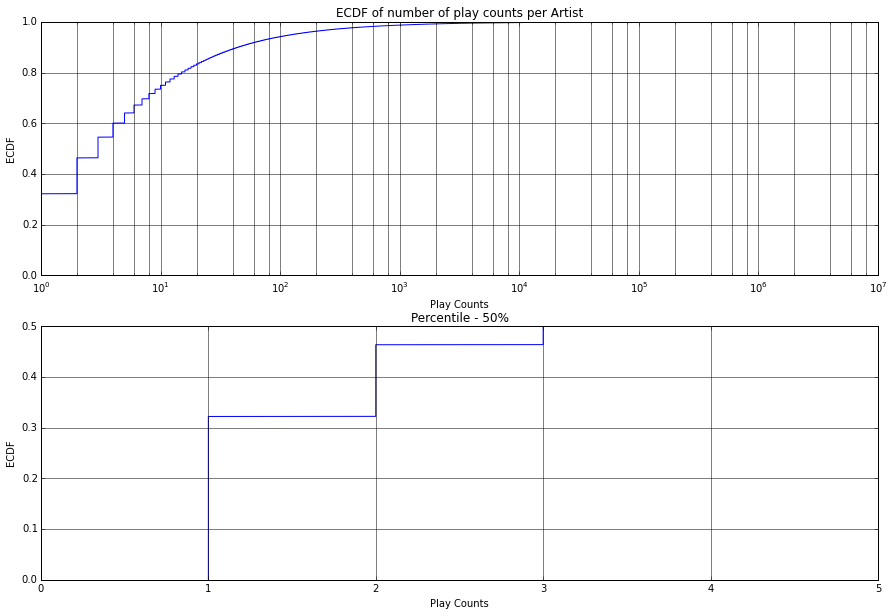

In [28]:
pdf = pd.DataFrame(data=sortedTopArtistsDF.collect())
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

plt.figure(figsize=(15,10))

plt.subplot(211)
plt.semilogx(Y, yvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist')

plt.subplot(212)
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('Percentile - 50%')
plt.axis([0,5,0,.5])

plt.show()

<font color='blue'> 
We sadly have a lot of artists played only once or twice (almost 50%). This percentage can come from the fact that we have dirty data as showed in the example above (featuring or collaborations between artists) or, a bit less likely, from the fact that some artists may be really unfamous.
</font>

#### Question 2.4
Plot a bar chart to show top 5 artists In terms of absolute play counts.

Comment the figure you just obtained:

* are these reasonable results?
* is looking at top-5 artists enough to learn more about your data?
* do you see anything strange in the data?

In [13]:
sortedPD = pd.DataFrame(data=sortedTopArtistsDF.limit(10).collect())
#artists = sortedPD[2].values.tolist()
#counts = sortedPD[1].values.tolist()
artists = sortedPD[2].values
counts = sortedPD[1].values

print(artists)
print(counts)

['Radiohead' 'The Beatles' 'Green Day' 'Metallica' 'System of a Down'
 'Pink Floyd' 'Nine Inch Nails' 'Modest Mouse' 'Bright Eyes' 'Nirvana']
[2502596 2259825 1931143 1543430 1426254 1399665 1361977 1328969 1234773
 1203348]


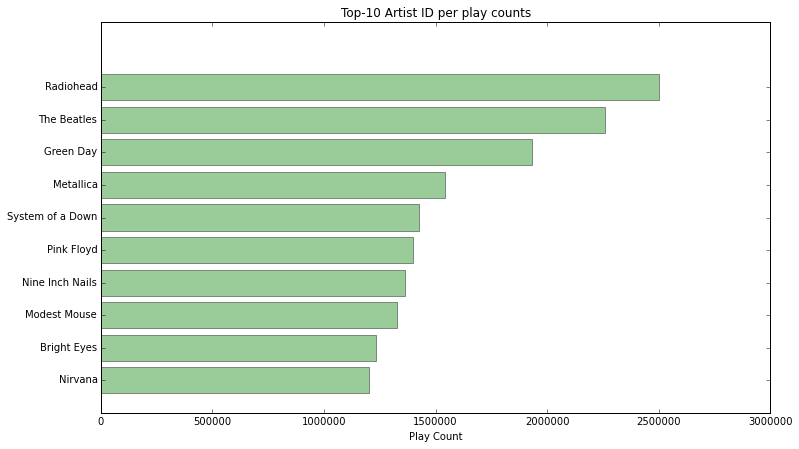

In [30]:
y_pos = np.arange(len(artists))
plt.figure(figsize=(12,7))

plt.barh(y_pos, counts, align='center', alpha=0.4, color='green')
plt.yticks(y_pos, artists)
plt.gca().invert_yaxis()
plt.xlabel('Play Count')
plt.title('Top-10 Artist ID per play counts')
plt.show()

<font color='blue'>
From this last chart, we don't spot any strange result, but in order to have a better understanding of our dataset, let's see also who are the most unfamous artists: are they really unfamous artists, or they have just weird IDs?
</font>

In [14]:
unfamousArtistsDF = userArtistCleanDF.groupBy('realArtistID').agg(sum('playCount').alias('sumPlayCount'))\
                    .join(artistDataDF, userArtistCleanDF.realArtistID == artistDataDF.artistID, how='left_outer')\
                    .drop('artistID').orderBy('sumPlayCount', ascending=1)

In [15]:
unfamousArtistsList = unfamousArtistsDF.limit(50).select('name').rdd.map(lambda x: x[0]).take(50)
#print(unfamousArtistsList)
pprint(unfamousArtistsList)

['Gender Wayang: Sukawati',
 'Roni Size Remix',
 '03. Reich- 18 Musicinas (Ens.Modern)',
 'ChroniX Aggression on iM Radio',
 'Professional Sntk',
 'I Try',
 'Osunlade-Power To Conquer (HOUSEMUSIQUE',
 'Mic-In',
 'Black Black Heart (hidden track)',
 '11 Istanbul Oriental Ensemble',
 '[Buffer: 28%] Fire And Ice',
 'bill bissett',
 "Don't Stop Get it Get it",
 '11. The Mary Martin Show',
 'Justin T. and Kylie M.',
 '10. Miner At The DialAVie',
 'pharoahe monch, shabaamsahdeeq',
 'Apple Tech Support Lines',
 'Karat and Peter Maffey',
 'Busty',
 'Bobby Leecan and Robert Cooksey',
 'Patti Labelle and Travis Tritt',
 'MandS Presents',
 'PRAXIS-Praxis-Transmutation (mutatis mutandis)-praxis',
 'Empty Chairs at Empty Tables',
 '\x83\x82\x81[\x83j\x83\x93\x83O\x96º\x81B\x91¼',
 '°í¸±¶ó',
 'Yuki Matsura and Mifuyu Hiragi',
 'John Mayer with Glen Phillips',
 'Sussi Lindstr#m',
 'Mektar',
 '[krz]Front 242, Rammstein and Laibach',
 'KingSize Records',
 'Frank Buthcer',
 'Gong Shapeshifter 12 Can Yo'

<font color='blue'>
Even though, the data should be clean and ready to train the model, we clearly spot a lot of what we can call _noise_ (i.e. some aspects of the problem which we cannot model due to their unpredictability nature).
As we suspected, we mainly have artists with wrong names or names badly mapped to IDs. Now, looking back to the ECDF of playcounts per artist where we got almost 50% of the musicians with less than 2 playcounts, we can say that a good portion is just noise, meaningless information. 
</font>

### Question 3

#### Question 3.1
Loading the data from `/datasets/lastfm/artist_data.txt` by using SparkSQL API and show 5 samples.

HINT: If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

<font color='blue'>
This has already been done in the previous questions
</font>

#### Question 3.2
Find 20 artists whose name contains "Aerosmith" inside. Take a look on artists that have ID equal to `1000010` and `2082323`. In your opinion, are they the same ?

HINT: Function `locate(sub_string, string)` can be useful in this case.

In [33]:
artistDataDF[locate("Aerosmith", artistDataDF.name) > 0].show()

artistDataDF[artistDataDF.artistID==1000010].show()
artistDataDF[artistDataDF.artistID==2082323].show()

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 2082323|01 Aerosmith|
+---

<font color='blue'> 
We can assume id ``1000010`` and id ``2082323`` refer to the same artist.
</font>

#### Question 3.3
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.

<font color='blue'> 
We already perfomed this previously.
</font>

#### Question 3.4
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.

In [34]:
artistAliasDF[ artistAliasDF.misspelledArtistID==1000010 ].show()
artistAliasDF[ artistAliasDF.misspelledArtistID==2082323 ].show()

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
+------------------+----------------+

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
|           2082323|         1000010|
+------------------+----------------+



<font color='blue'>
As we can see, in the first case there is no entry for id ``1000010`` because it's correct, while the second id is wrong and it points to the right one.
</font>

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and to re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that map a non-standard ids to a standard ids. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.

HINT: Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.

In [33]:
artistAliasDict = artistAliasDF.rdd.map(lambda row: ( row[0] , row[1])).collectAsMap()

#### Question 4.2
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.

**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [17]:
userArtistCleanDF.groupBy(['userID', 'realArtistID']).count().orderBy('count', ascending=0).show(5)

+-------+------------+-----+
| userID|realArtistID|count|
+-------+------------+-----+
|2133748|     1018110|   94|
|2052189|     1082784|   71|
|2360120|         122|   68|
|2302495|     1000024|   65|
|1053375|     1001819|   57|
+-------+------------+-----+
only showing top 5 rows



<font color='blue'>
This table tells us how many times a certain user played a certain artist and the value of count is the times ``standard_artist_id`` was misspelled.
</font>

In [34]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAliasDict.get(fields[1], fields[1])
    return ((fields[0], finalID), fields[2]) 

def correctFormat(fields):
    return (fields[0][0], fields[0][1], fields[1])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd\
    .map(replaceMispelledIDs)\
    .reduceByKey(lambda x,y: x + y)\
    .map(correctFormat),
    userArtistDataSchema
)

newUserArtistDF.cache()
newUserArtistDF.show()
t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2417377| 1000985|        1|
|2073546|    1292|       11|
|1066672|    2530|       25|
|2086518| 7018288|        8|
|2018464| 1115674|        1|
|1017089|    3621|        1|
|2364410| 1179984|        2|
|2104005|    3161|       69|
|2161844| 1002134|        4|
|2031585| 1001277|        1|
|2287934|     600|        1|
|2272723|     979|        1|
|2004540| 1245054|        1|
|1051685| 1009657|        1|
|1042691| 1099195|        1|
|2310435| 1195863|       17|
|2345778|     860|       12|
|1054211| 1155691|       11|
|2354192|    1986|        2|
|2215873| 1012257|      447|
+-------+--------+---------+
only showing top 20 rows

The script takes 88.385719 seconds


In [19]:
newUserArtistDF.orderBy('playCount', ascending=0).show(5)

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2064012|    4468|   439771|
|1059637| 1002095|   433060|
|1059637| 1026440|   155895|
|2069889| 1002095|   101076|
|2020513| 1007801|    89592|
+-------+--------+---------+
only showing top 5 rows



<font color='blue'>
To be sure that we have done the right action, we perform again the same test as before (i.e. counting how many times the ``standard_artist_id`` was misspelled in the table).
</font>

In [39]:
newUserArtistDF.groupBy(['userID', 'artistID']).count().orderBy('count', ascending = 0).show(5)

+-------+--------+-----+
| userID|artistID|count|
+-------+--------+-----+
|2019972| 2097754|    1|
|2312043| 1078383|    1|
|1043734| 1002080|    1|
|2294193| 6941881|    1|
|2112254| 1132532|    1|
+-------+--------+-----+
only showing top 5 rows



<font color='blue'>
Now, each pair of ``userID`` and ``artistID`` appears only once.
</font>

#### Question 4.3
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task. 

We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner. 

The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`

To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.


In [20]:
from time import time

bArtistAlias = sc.broadcast(artistAliasDict)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return ((fields[0], finalID), fields[2]) # userID + missing + playcount

def correctFormat(fields):
    return (fields[0][0], fields[0][1], fields[1])

t0 = time()

bNewUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd\
    .map(replaceMispelledIDs)\
    .reduceByKey(lambda x,y: x + y)\
    .map(correctFormat),
    userArtistDataSchema
)

bNewUserArtistDF.cache()
bNewUserArtistDF.show()
t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1030953| 1001909|        1|
|2417377| 1000985|        1|
|2073546|    1292|       11|
|2047347| 1036119|        2|
|2405301| 1000505|      173|
|2004875| 1090663|        3|
|2272915| 1001019|        8|
|2086518| 7018288|        8|
|2018464| 1115674|        1|
|1017089|    3621|        1|
|2104005|    3161|       69|
|1023567| 1047607|        1|
|1072606| 1046576|        1|
|2161844| 1002134|        4|
|2031585| 1001277|        1|
|2287934|     600|        1|
|2272723|     979|        1|
|1001286|    3328|        5|
|2004540| 1245054|        1|
|1051685| 1009657|        1|
+-------+--------+---------+
only showing top 20 rows

The script takes 115.008380 seconds


Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1

How many unique artists? Compare with the result when using old data.

In [41]:
uniqueArtists = newUserArtistDF.select('artistID').distinct().count()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1568126


<font color='blue'> 
We previously obtained 1631028 different artists, around 60000 artists more. We now might be sure that we have unique artists, but strangely enough we still have problems: some artists still have two different IDs. 
</font>

In [35]:
newTopArtistsDF2 = newUserArtistDF.groupBy('artistID').agg(sum('playCount').alias('sumPlayCount'))\
                              .join(artistDataDF, newUserArtistDF.artistID == artistDataDF.artistID, how='left_outer')\
                              .orderBy('sumPlayCount', ascending=0)\
                              .drop(artistDataDF.artistID)

newTopArtistsDF2[newTopArtistsDF2.artistID==4622].show()
newTopArtistsDF2[newTopArtistsDF2.artistID==10441043].show()

+--------+------------+---------------+
|artistID|sumPlayCount|           name|
+--------+------------+---------------+
|    4622|      232945|The Get Up Kids|
+--------+------------+---------------+

+--------+------------+---------------+
|artistID|sumPlayCount|           name|
+--------+------------+---------------+
|10441043|           1|The Get Up Kids|
+--------+------------+---------------+



<font color='blue'>
We want now to fix this issue.
</font>

In [37]:
newTopArtistsDF = newUserArtistDF.groupBy('artistID').agg(sum('playCount').alias('sumPlayCount'))\
                              .join(artistDataDF, newUserArtistDF.artistID == artistDataDF.artistID, how='left_outer')\
                              .groupBy('name').agg(sum('sumPlayCount').alias('sumPlayCount'))\
                              .orderBy('sumPlayCount', ascending=0)

newTopArtistsDF.show()

+--------------------+------------+
|                name|sumPlayCount|
+--------------------+------------+
|           Radiohead|     2502596|
|         The Beatles|     2259825|
|           Green Day|     1931143|
|           Metallica|     1543430|
|    System of a Down|     1426254|
|          Pink Floyd|     1399665|
|     Nine Inch Nails|     1361977|
|        Modest Mouse|     1328969|
|         Bright Eyes|     1234773|
|             Nirvana|     1203348|
|                Muse|     1148684|
| Death Cab for Cutie|     1117277|
|Red Hot Chili Pep...|     1088701|
|       Elliott Smith|     1080542|
|           Rammstein|     1047119|
|         Linkin Park|     1028921|
|                  U2|     1015494|
|           Nightwish|     1010869|
|            Coldplay|     1001417|
|            Interpol|      979770|
+--------------------+------------+
only showing top 20 rows



#### Question 5.2

Who are the top-10 artistis?
  * In terms of absolute play counts
  * In terms of "audience size", that is, how many users listened to one of their track at least once
  
Plot the results, and explain the figures you obtain.

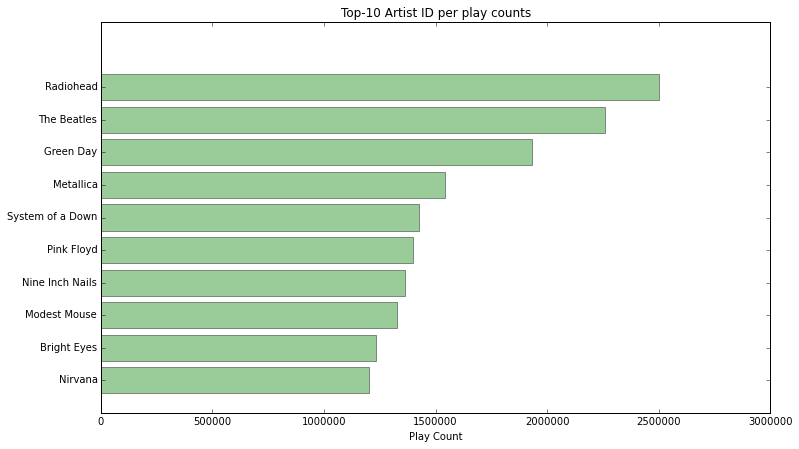

In [44]:
topArtistsPD = pd.DataFrame(data=newTopArtistsDF.limit(10).collect())
counts = topArtistsPD[1].values
artists = topArtistsPD[0].values

y_pos = np.arange(len(artists))
plt.figure(figsize=(12,7))

plt.barh(y_pos, counts, align='center', alpha=0.4, color='green')
plt.yticks(y_pos, artists)
plt.gca().invert_yaxis()
plt.xlabel('Play Count')
plt.title('Top-10 Artist ID per play counts')
plt.show()

In [39]:
popularArtistsDF = newUserArtistDF.select('userID', 'artistID').groupBy('artistID').count()\
               .join(artistDataDF, newUserArtistDF.artistID==artistDataDF.artistID, how='left_outer')\
               .groupBy('name').agg(sum('count').alias('audience'))\
               .orderBy('audience', ascending = 0)#.drop('artistID').cache()
popularArtistsDF.show() 
popularArtistsDF[popularArtistsDF.name=='The Get Up Kids'].show()

+--------------------+--------+
|                name|audience|
+--------------------+--------+
|           Radiohead|   45630|
|           Green Day|   43883|
|         The Beatles|   40919|
|            Coldplay|   38497|
|             Nirvana|   36823|
|Red Hot Chili Pep...|   36036|
|                  U2|   34853|
|           Metallica|   32337|
|              Weezer|   31951|
|           [unknown]|   31324|
|     Franz Ferdinand|   30692|
|          Pink Floyd|   30661|
|         The Killers|   30214|
|   The White Stripes|   29804|
|            The Cure|   29161|
|                Beck|   29153|
|        Led Zeppelin|   29117|
|              Eminem|   28974|
|              R.E.M.|   28885|
|               Queen|   28457|
+--------------------+--------+
only showing top 20 rows

+---------------+--------+
|           name|audience|
+---------------+--------+
|The Get Up Kids|    8799|
+---------------+--------+



<font color='blue'>
Notice that we are now working with names, instead of artist IDs which turned out to be misleading in some cases.
</font>

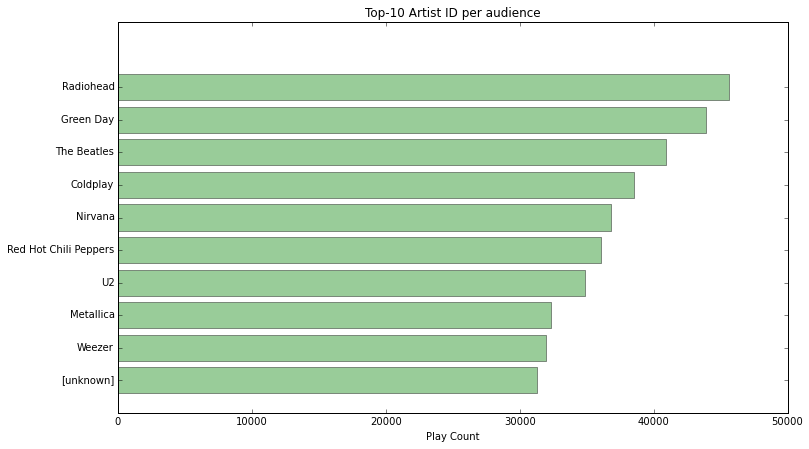

In [46]:
sortedPD = pd.DataFrame(data=popularArtistsDF.limit(10).collect())
artists = sortedPD[0].values
counts = sortedPD[1].values

y_pos = np.arange(len(artists))
plt.figure(figsize=(12,7))

plt.barh(y_pos, counts, align='center', alpha=0.4, color='green')
plt.yticks(y_pos, artists)
plt.gca().invert_yaxis()
plt.xlabel('Play Count')
plt.title('Top-10 Artist ID per audience')
plt.show()

<font color='blue'>
We notice that having a lot of plays does not mean being popular. The Green Day seems to have a wider audience compared to The Beatles. This is reasonable because maybe The Beatles are listened from always the same people, while the Green Day may be played by young teenagers that talk to each other and share their music rapidly. Same goes for Pink Floyd, Nine Inch Nails, Modest Mouse, Bright Eyes that are replaced by U2 and RHCP. It's funny, but also worrying for our recommender system, that we have the artist '[unknown]' among the most populars. This means we're still dealing with 'dirty' data.
</font>

<font color='blue'>
A part from some small changes in the ranking, the previous two graphs show almost the same artist names. So we think it's worth and maybe more meaningful investigating on a different indicator: the ratio between the number of different users that played an artist and the total play counts of that artist.
</font>

In [40]:
relAudienceArtistsDF = newTopArtistsDF\
                        .join(popularArtistsDF, popularArtistsDF.name==newTopArtistsDF.name, how='left_outer')\
                        .drop(popularArtistsDF.name)
relAudienceArtistsDF.orderBy('sumPlayCount', ascending=0).show()

+------------+--------------------+--------+
|sumPlayCount|                name|audience|
+------------+--------------------+--------+
|     2502596|           Radiohead|   45630|
|     2259825|         The Beatles|   40919|
|     1931143|           Green Day|   43883|
|     1543430|           Metallica|   32337|
|     1426254|    System of a Down|   27199|
|     1399665|          Pink Floyd|   30661|
|     1361977|     Nine Inch Nails|   25410|
|     1328969|        Modest Mouse|   27731|
|     1234773|         Bright Eyes|   22159|
|     1203348|             Nirvana|   36823|
|     1148684|                Muse|   26598|
|     1117277| Death Cab for Cutie|   23027|
|     1088701|Red Hot Chili Pep...|   36036|
|     1080542|       Elliott Smith|   19385|
|     1047119|           Rammstein|   24062|
|     1028921|         Linkin Park|   26581|
|     1015494|                  U2|   34853|
|     1010869|           Nightwish|   14838|
|     1001417|            Coldplay|   38497|
|      979

In [41]:
relAudienceArtistsRDD = relAudienceArtistsDF.rdd.filter(lambda x: (x[2] is not None and x[0] is not None))\
                                                .map(lambda x: (x[1], x[0], float(x[2])/float(x[0])))

In [42]:
relAudienceSchema = StructType([ \
    StructField("artist", StringType(), True), \
    StructField("sumPlayCount", IntegerType(), True), \
    StructField("relAudience", FloatType(), True)])
relAudienceDF = sqlContext.createDataFrame(relAudienceArtistsRDD, relAudienceSchema)
famousArtistsRelAudienceDF = relAudienceDF.filter(relAudienceDF.sumPlayCount > 500)
famousArtistsRelAudienceDF.show()

+--------------------+------------+-----------+
|              artist|sumPlayCount|relAudience|
+--------------------+------------+-----------+
|               )Eib(|        1612| 0.14764269|
|              *NSYNC|       47941|0.097682565|
|              5 Bugs|         895|0.045810055|
|          63 Crayons|         541| 0.09242144|
|? And the Mysterians|        1508| 0.25132626|
|            Abruptum|        1759|0.107447416|
| Agents & Ville Valo|        1164|  0.1176976|
|              Amulet|        3143| 0.06745148|
|      Anais Mitchell|         770|0.045454547|
|         André Hazes|        9424| 0.07003395|
|             Anodyne|        2254|0.071428575|
|            Art Zoyd|         751| 0.07989348|
|         Ashley Park|         808| 0.16584158|
|          B! Machine|        1707| 0.07088459|
|                 BGM|        4229|0.046346653|
|          Baby Chaos|         704| 0.04403409|
|     Barbie's Cradle|        1046|0.043977056|
|           Batmobile|        4295|0.050

In [39]:
famousArtistsRelAudienceDF.orderBy('sumPlayCount', ascending=0).show()

+--------------------+------------+-----------+
|              artist|sumPlayCount|relAudience|
+--------------------+------------+-----------+
|           Radiohead|     2502596|0.018233066|
|         The Beatles|     2259825|0.018107153|
|           Green Day|     1931143|0.022723848|
|           Metallica|     1543430|0.020951388|
|    System of a Down|     1426254|0.019070236|
|          Pink Floyd|     1399665|0.021905957|
|     Nine Inch Nails|     1361977|0.018656703|
|        Modest Mouse|     1328969|0.020866552|
|         Bright Eyes|     1234773| 0.01794581|
|             Nirvana|     1203348|0.030600458|
|                Muse|     1148684|0.023155194|
| Death Cab for Cutie|     1117277| 0.02060993|
|Red Hot Chili Pep...|     1088701|0.033099998|
|       Elliott Smith|     1080542| 0.01794007|
|           Rammstein|     1047119| 0.02297924|
|         Linkin Park|     1028921|0.025833858|
|                  U2|     1015494|0.034321226|
|           Nightwish|     1010869| 0.01

In [40]:
famousArtistsRelAudienceDF.orderBy('relAudience', ascending=0).show()

+--------------------+------------+-----------+
|              artist|sumPlayCount|relAudience|
+--------------------+------------+-----------+
|    iPodder Dev Team|         224|     0.9375|
|  ATX Records Clique|          72|  0.8333333|
|Sony Pictures Ent...|         115| 0.82608694|
|     Nino Astronauta|          63| 0.82539684|
|    Hot Young Priest|          62| 0.82258064|
|            DJ Panko|          67|  0.8208955|
|    The day after...|          60| 0.81666666|
|              Dubtex|          59|  0.8135593|
|      The Good Looks|          58|  0.8103448|
|          David Holt|          73|  0.8082192|
|Veronica Lipgloss...|          57| 0.80701756|
|        Lise Liddell|          56|  0.8035714|
|Webb Wilder & The...|          66|  0.8030303|
|          Kevin Kelm|          76| 0.80263156|
| Conspiracion Alfa 5|          70|        0.8|
|The Chris Vestre ...|          57|  0.7894737|
|            Shikasta|          64|    0.78125|
|    Jessie and Layla|          59|   0.

<font color='blue'>
These results give us some indication about the attractiveness of an artist and its ability to "connect" the audience. In fact, if this ratio tends to 1, this means that users are getting annoyed after a few songs. On the other hand, if the ratio is near to 0, the artist is likely possible to have a loyal and faithful audience. 

In a song-oriented recommending system, this indicator may be used to avoid recommending songs one after the other from the same artist.
</font>

#### Question 5.3

Who are the top-10 users?
  * In terms of absolute play counts
  * In terms of "curiosity", that is, how many different artists they listened to

Plot the results

<font color='blue'> 
We have already provided the numbers of absolute play counts for the top-10 users in answer 2.1.
</font>

In [43]:
curiousUsersDF = newUserArtistDF.select('userID', 'artistID').groupBy('userID').count()\
               .orderBy('count', ascending = 0).cache()

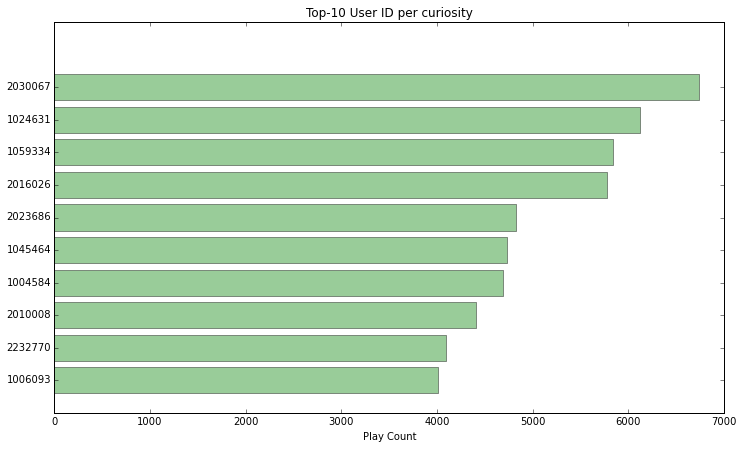

In [53]:
curiousUsersPD = pd.DataFrame(data=curiousUsersDF.limit(10).collect())
users = curiousUsersPD[0].values
counts = curiousUsersPD[1].values

y_pos = np.arange(len(artists))
plt.figure(figsize=(12,7))

plt.barh(y_pos, counts, align='center', alpha=0.4, color='green')
plt.yticks(y_pos, users)
plt.gca().invert_yaxis()
plt.xlabel('Play Count')
plt.title('Top-10 User ID per curiosity')
plt.show()

<font color='blue'>
We can now study a bit more this last result: are these curious users also the most active users?
Let's create a ranking for the most curious users and a ranking for the most active users and then combine them together to see some interesting results.
</font>

In [44]:
userCuriosityRankSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistCount", IntegerType(), True),\
    StructField("curiosityRank", LongType(), True)])

userCuriosityRankedRDD = curiousUsersDF.orderBy('count', ascending=0)\
                                    .rdd.zipWithIndex().map(lambda x : (x[0][0], x[0][1], x[1]+1))

userCuriosityRankedDF = sqlContext.createDataFrame(userCuriosityRankedRDD, userCuriosityRankSchema)
userCuriosityRankedDF.show(5)

+-------+-----------+-------------+
| userID|artistCount|curiosityRank|
+-------+-----------+-------------+
|2030067|       6735|            1|
|1024631|       6125|            2|
|1059334|       5839|            3|
|2016026|       5773|            4|
|2023686|       4822|            5|
+-------+-----------+-------------+
only showing top 5 rows



In [49]:
userActivityRankSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("playCount", IntegerType(), True),\
    StructField("activityRank", LongType(), True)])

userActivityRankedRDD = userActivity.orderBy('sum(playCount)', ascending=0)\
                                    .rdd.zipWithIndex().map(lambda x : (x[0][0], x[0][1], x[1]+1))

userActivityRankedDF = sqlContext.createDataFrame(userActivityRankedRDD, userActivityRankSchema)
userActivityRankedDF.show(5)

+-------+---------+------------+
| userID|playCount|activityRank|
+-------+---------+------------+
|1059637|   674412|           1|
|2064012|   548427|           2|
|2069337|   393515|           3|
|2023977|   285978|           4|
|1046559|   183972|           5|
+-------+---------+------------+
only showing top 5 rows



In [50]:
curiousActiveRankDF = userActivityRankedDF\
                            .join(userCuriosityRankedDF, userActivityRankedDF.userID == userCuriosityRankedDF.userID)\
                            .drop(userCuriosityRankedDF.userID)

curiousActiveRankDF = curiousActiveRankDF\
            .select(curiousActiveRankDF.userID, curiousActiveRankDF.activityRank, curiousActiveRankDF.curiosityRank, \
                    curiousActiveRankDF.playCount, curiousActiveRankDF.artistCount)\
            .cache()

<font color='blue'>
Let's see how the most active users perform in terms of curiosity...
</font>

In [55]:
curiousActiveRankDF.orderBy(curiousActiveRankDF.activityRank, ascending=1).show(10)

+-------+------------+-------------+---------+-----------+
| userID|activityRank|curiosityRank|playCount|artistCount|
+-------+------------+-------------+---------+-----------+
|1059637|           1|        16857|   674412|        359|
|2064012|           2|        95555|   548427|         57|
|2069337|           3|        28615|   393515|        257|
|2023977|           4|        89317|   285978|         67|
|1046559|           5|         1250|   183972|       1068|
|1052461|           6|        31132|   175822|        241|
|1070932|           7|        63681|   168977|        120|
|1031009|           8|         3400|   167273|        738|
|2020513|           9|        62615|   165642|        122|
|2062243|          10|         3354|   151504|        742|
+-------+------------+-------------+---------+-----------+
only showing top 10 rows



<font color='blue'>
Even if the most active users listened to a lot of different artists, we can definitely say that they are not among the most curious users.
What about the inverse?
</font>

In [56]:
curiousActiveRankDF.orderBy(curiousActiveRankDF.curiosityRank, ascending=1).show(10)

+-------+------------+-------------+---------+-----------+
| userID|activityRank|curiosityRank|playCount|artistCount|
+-------+------------+-------------+---------+-----------+
|2030067|        1267|            1|    23054|       6735|
|1024631|          15|            2|   122316|       6125|
|1059334|          32|            3|    80486|       5839|
|2016026|          90|            4|    58967|       5773|
|2023686|          31|            5|    80488|       4822|
|1045464|         127|            6|    53202|       4734|
|1004584|         432|            7|    35315|       4690|
|2010008|          35|            8|    77724|       4411|
|2232770|        1594|            9|    20887|       4090|
|1006093|        1639|           10|    20638|       4005|
+-------+------------+-------------+---------+-----------+
only showing top 10 rows



<font color='blue'>
Here we have a more diverse risult: we have some of the most curious users which are also quite active, not in the top 10 though. The second most curious user is 15th in terms of activity, but the most curious user scores pretty bad in activity (only 1267th).
</font>

<font color='blue'>
Let's plot the distribution of curiosity among users.
</font>

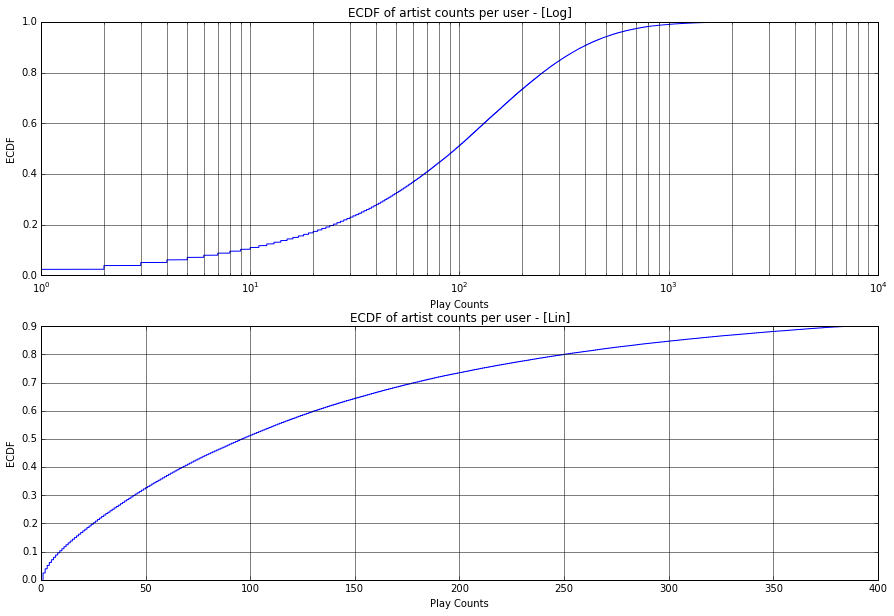

In [60]:
pdf = pd.DataFrame(data=curiousActiveRankDF.select('userID', 'artistCount').collect())
Y= np.sort(pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

plt.figure(figsize=(15,10))

plt.subplot(211)
plt.semilogx(Y, yvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of artist counts per user - [Log]')

plt.subplot(212)
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of artist counts per user - [Lin]')
plt.axis([0,400,0,.9])

plt.show()

<font color='blue'>
From these plots, we can say that the majority (~90%) of users listened less than 400 different artists. This give us some indication on the average curiosity of a user.
</font>

<font color='blue'>
For visulization purposes, here we plot the distribution of users according to their cumulative counts on songs played and different artists.
</font>

In [71]:
userRank = curiousActiveRankDF.select('userID', 'playCount', 'artistCount').collect()
userRank = list(zip(*[f for f in userRank[0:1000]]))

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


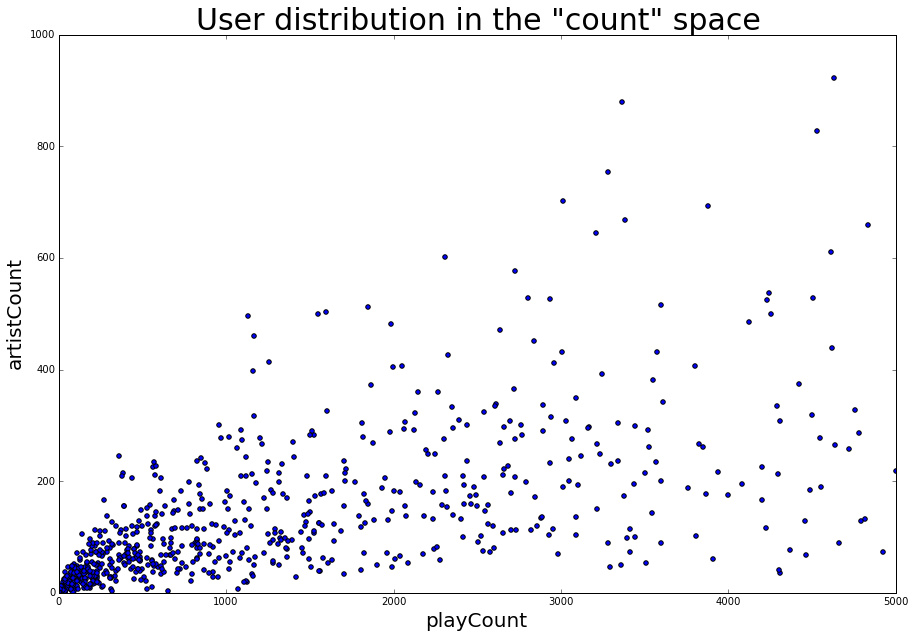

In [86]:
fig = plt.figure(figsize=(15,10) )
ax = fig.add_subplot(111)

ax.scatter(userRank[1], userRank[2])
ax.set_xlabel('playCount', fontsize=20)
ax.set_ylabel('artistCount', fontsize=20)
ax.set_ylim(top=1000, bottom=0)#1000
ax.set_xlim(right=5000, left=0)#5000
plt.title('User distribution in the \"count\" space', fontsize=30)

plt.show()

<font color='blue'>
A single point in this graph represents a user of our dataset: in the y axis we have how many different artists she played, while in the x axis how many play counts she has.
This plot has been limited to the useful region of interest where the majority of users lie.
<br><br>
We can try to spot some trends in the user activity and we can make some judgements on the correlation between these two features.
<br><br>
If we image a cone starting from the origin, going to the upper right direction, the more this cone is thin, the higher the correlation is. With this dataset, we have a very wide cone which means the correlation is low. The samples proving this lie on the lower right corner. Looking for improvements for increasing the accuracy of the recommending system, unfortunately, it seems useless to consider this information.
</font>

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... |  |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is converged. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we init the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row from $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:

Initialize $X$, $Y$

**while**(convergence is not true) **do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**

For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute 􏰀$\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute 􏰁$\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [2]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separators,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( xtractFields )
   
                    # filter out the special tuples
                    .filter(lambda x : x[0] != -1 and x[1] != -1)
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )


#### Question 6.2
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.

HINT: Using broadcast varible can help us increase the effiency.

In [76]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    #artistID = str(bArtistAlias.value.get(int(artistID), artistID))
    if int(artistID) in bArtistAlias.value.keys():
        artistID = str(bArtistAlias.value[int(artistID)])
    return ((userID, artistID), count)

def correctFormat(fields):
    return (fields[0][0], fields[0][1], fields[1])


userArtistDataRDD = rawUserArtistData.map(disambiguate)\
                                     .reduceByKey(lambda x,y: x + y)\
                                     .map(lambda fields : (fields[0][0], fields[0][1], fields[1]))
userArtistDataRDD.cache()
userArtistDataRDD.take(10)


[('2078157', '1008663', '4'),
 ('2166125', '1004481', '4'),
 ('2336601', '1261311', '2'),
 ('2420521', '10729338', '1'),
 ('2101876', '1199215', '1'),
 ('2101061', '6915662', '1'),
 ('2038737', '4746', '5'),
 ('2056726', '1165805', '1'),
 ('2082631', '393', '4'),
 ('1050632', '1060099', '10')]

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.

In [4]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [78]:
allData = userArtistDataRDD.map(lambda r: Rating(r[0], r[1], r[2])).repartition(20).cache()

#### Question 7.2
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
* `training data` is the input data you decide to feed to the ALS algorithm
* `rank` is the number of latent features

We can also use some additional parameters to adjust the quality of the model. Currently, let's set 

- `rank=10`
- `iterations=5`
- `lambda_=0.01`
- `alpha=1.0` 

to build model.

In [79]:
t0 = time()
model = ALS.trainImplicit(allData, rank=10, iterations=5, lambda_=0.01, alpha=1. )
t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 142.197611 secs


#### Question 7.3
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [64]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
t0=time()
model.save(sc, 'lastfm_model.spark')
t1=time()
print("finish loading model in %f secs" % (t1 - t0))

Deleted lastfm_model.spark
finish loading model in 3.945436 secs


#### Question 7.4
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.

In [65]:
t0 = time()
model = MatrixFactorizationModel.load(sc, 'lastfm_model.spark')
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 1.233607 secs


#### Question 7.5
Print the first row of user features in our model.

In [20]:
model.userFeatures().take(1)


[(120,
  array('d', [0.226030632853508, 0.00039635426946915686, 0.18772085011005402, -0.027264360338449478, -0.11762460321187973, -0.031778495758771896, 0.13494373857975006, -0.1541258543729782, -0.15936601161956787, -0.11824899166822433]))]

### Question 8
Show the top-5 artist names recommendated for user `2093760`.

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [64]:
# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760,5))


# construct set of recommendated artists
recArtists = set([prod.product for prod in recommendations])

print(recArtists)

{1300642, 1001819, 4605, 2814, 1037970}


In [22]:

# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByIDRDD = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)


In [65]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    global recArtists
    if (line[0] in recArtists):
        return True
    else:
        return False

recList = artistByIDRDD.filter(artistNames).values().collect()

print(recList)

['50 Cent', 'Snoop Dogg', 'Kanye West', '2Pac', 'The Game']


<font color='blue'> 
These recommended artists are pretty famous so we wonder if this user had already listened to them.
</font>

# Let's improve the recommendation of new music!

<font color='blue'>
Now, here we want to do a different thing: we want to recommend artist never played by the user, to give advantages to both artists and users.
In one hand, users may have the opportunity to listen to new music while not-well known artists may have the possibility to emerge.
</font>

In [70]:
def checkAlreadyPlayedArtist(userID, artistID):
    if newUserArtistDF[newUserArtistDF.userID==userID][newUserArtistDF.artistID==artistID].count() != 0:
        return True
    else:
        return False    

In [71]:
singleUser = 2093760
for ID in recArtists:
    print(checkAlreadyPlayedArtist(singleUser, ID))


False
False
False
False
False


<font color='blue'>
This user was lucky to get new recommended artists, not listened before, but she was not a very curious user.
</font>

In [72]:
newUserArtistDF[newUserArtistDF.userID==singleUser].show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2093760|     942|        7|
|2093760|     378|        1|
|2093760|     813|        2|
|2093760|    1180|        1|
|2093760| 1255340|        3|
+-------+--------+---------+



<font color='blue'>
This might be not always the case, let's see another user where we can show a possible problem with this recommendation system.
</font>

<font color='blue'>
Just a couple of examples for justifing what we have just said above. 
</font>

In [74]:
user = 1059637
recommendations = (model.recommendProducts(user,5))

recArtists = set([prod.product for prod in recommendations])
recList = artistByIDRDD.filter(artistNames).values().collect()
i = 0
for ID in recArtists:
    print(checkAlreadyPlayedArtist(user, ID), recList[i])
    i+=1
    #print(checkAlreadyPlayedArtist(user, ID))


True Rooney
True The Living End
False Phantom Planet
False The Ataris
True The All-American Rejects


In [75]:
user = 2030067
recommendations = (model.recommendProducts(user,5))

recArtists = set([prod.product for prod in recommendations])
recList = artistByIDRDD.filter(artistNames).values().collect()
i = 0
for ID in recArtists:
    print(checkAlreadyPlayedArtist(user, ID), recList[i])
    i+=1


True Enigma
True Pet Shop Boys
True Madonna
True ABBA
True a-ha


<font color='blue'>
This is what we want to avoid. 
</font>

# Prediction 2.0

<font color='blue'>
Some users may already know the artists we suggest them which is nice if we can include one of their new songs, but with this dataset it's not possible.
We think suggesting artists already known to the user is useless and annoying, so we want to recommend new users, unknown to the user.
</font>

In [76]:
def predict(model, user, N):
    artistsToPredict = userCuriosityRankedDF.filter(userCuriosityRankedDF.userID == user)\
                                            .select('artistCount').collect()[0][0] + N
    
    recommendations = model.recommendProducts(user,artistsToPredict)
    
    fullRecArtists = set([prod.product for prod in recommendations])
    recArtists = [] 
    
    for artistID in fullRecArtists:
        if len(recArtists) == N:
            break
        if checkAlreadyPlayedArtist(user, artistID):
            continue
        recArtists.append(artistID)
    
    return recArtists

In [77]:
recArtists = predict(model, 1059637, 5)
print(recArtists)
recList = artistByIDRDD.filter(artistNames).values().collect()
print(recList)

[1151014, 1001529, 1001531, 1077309, 2115]
['Belle and Sebastian', 'Le Tigre', 'Spitalfield', 'Billy Talent', 'The Cars']


In [143]:
recArtists = predict(model, 2030067, 5)
print(recArtists)
recList = artistByIDRDD.filter(artistNames).values().collect()
print(recList)

[1245185, 4, 1007621, 17, 1073173]
['Joss Stone', 'Marianne Faithfull', 'Suburban Tribe', 'Dressy Bessy', 'Cranes']


<font color='blue'>
This method however is affected by a big disadvange: it's difficult to evaluate. Due to its nature, it is **user-dependent**: someone could appreciate the diversity of music while "conservative" users may blame the system for recommending always unknown artists.
</font>

# Prediction 3.0

<font color='blue'>
In the spirit of helping emerging artists to getting known, here instead of simply recommending the top artists we want to diversificate the recommendation based on the **audience size**. In this way, we give a wider view on the music scene to the user, but also a higher chance of becoming popular for artists with a small audience.
</font>

In [145]:
audiencePerArtistsDF = newUserArtistDF.select('userID', 'artistID').groupBy('artistID').count()\
                        .join(artistDataDF, newUserArtistDF.artistID==artistDataDF.artistID, how='left_outer')\
                        .drop(artistDataDF.artistID)

In [161]:
audiencePerArtistsDF.show()

+--------+-----+--------------------+
|artistID|count|                name|
+--------+-----+--------------------+
|      26| 1132|       Barry Adamson|
|     964|  656|           Jellyfish|
|    1677|   48|            Neoangin|
|    1697|  793|             Shantel|
|    1950|  105|   Lordz Of Brooklyn|
|    2040|    3|              Hi-way|
|    2214| 1332|              Sun Ra|
|    2250|    1|        Maru + Comix|
|    2509|   13|                Simm|
|    2927|   12|          Emergency!|
|    3091|   11|  PQM featuring Cica|
|    3506|    1|    KingSize Records|
|    4590|    2|      Roots & Fierce|
|    5385|   34|mathias schaffhauser|
|    5409|14296|                 AFI|
|    5556| 1814|     Hundred Reasons|
| 1000061|    1|Capdown (Bollucks...|
| 1000311| 1541|       Steve Winwood|
| 1000313| 5986| Super Furry Animals|
| 1001409|   43|            Pnu Riff|
+--------+-----+--------------------+
only showing top 20 rows



In [238]:
def predict2(model, user, N):
    epsilon = 0
    
    artistsToPredict = userCuriosityRankedDF.filter(userCuriosityRankedDF.userID == user)\
                                            .select('artistCount').collect()[0][0] + N + epsilon

    recommendations = model.recommendProducts(user,artistsToPredict)
    recArtists = [prod.product for prod in recommendations]
  
    listenedArtists = userArtistDataRDD.filter(lambda x:int(x[0])==user).map(lambda x:(int(x[1]))).cache().collect()
    
    newArtists = audiencePerArtistsDF.rdd.filter(lambda x : x[0] not in listenedArtists and x[0] in recArtists)\
                                         .sortBy(lambda x: -x[1]).map(lambda x:x[2]).cache().collect()
    
    L = len(newArtists)
    finalList = []
    for i in range(N):
        finalList.append(newArtists[i*int(L/N)])
    
    print(finalList)

In [239]:
predict2(model, 2030067, 6)

['The Killers', 'Supreme Beings of Leisure', 'Michael Franti & Spearhead', 'Euphoria', 'Chemlab', 'The Seekers']


#### IMPORTANT NOTE

At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.

In [135]:

def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
#unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:

- rank=10
- iterations=5
- lambda_=0.01
- alpha=1.0

In [127]:
trainData, cvData = allData.randomSplit([0.9, 0.1])
trainData.cache()
cvData.cache()

PythonRDD[798] at RDD at PythonRDD.scala:48

In [22]:
t0 = time()
model = ALS.trainImplicit(trainData, rank=10, iterations=5, lambda_=0.01, alpha=1. )
t1 = time()
print("Finish training model in %f secs" % (t1 - t0))


Finish training model in 40.494066 secs


#### Area under the ROC curve: a function to compute it

In [128]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [129]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: \
                            ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.

In [25]:

t0 = time()
auc = calculateAUC( cvData , bAllItemIDs , model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))


auc= 0.9666438094939122
finish in 28.975797 seconds


#### Question 9.3
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective. 

Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.

In [130]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda x,y : x+y).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1] , 0.0)))

In [27]:
auc = calculateAUC(cvData, bAllItemIDs, predictMostListened)
print(auc)


0.9376118319377396


## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.

In [133]:
trainData, cvData = allData.randomSplit([0.9, 0.1])
trainData.cache()
cvData.cache()

PythonRDD[823] at RDD at PythonRDD.scala:48

In [136]:
evaluations = []

for r in [10, 50]:
    for l in [1.0, 0.0001]:
        for a in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (r, l, a))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData, rank = r, lambda_ = l, alpha = a )
            
            auc = calculateAUC(cvData , bAllItemIDs , model.predictAll)
            
            evaluations.append(((r, l, a), auc))
            
            unpersist(model)

evaluations.sort(key=lambda x:x[1], reverse=True)
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()


Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000
                    0         1
0     (50, 1.0, 40.0)  0.976057
1  (10, 0.0001, 40.0)  0.975469
2     (10, 1.0, 40.0)  0.975335
3  (50, 0.0001, 40.0)  0.974842
4      (10, 1.0, 1.0)  0.969971
5      (50, 1.0, 1.0)  0.966686
6   (10, 0.0001, 1.0)  0.964916
7   (50, 0.0001, 1.0)  0.953445


PythonRDD[823] at RDD at PythonRDD.scala:48

#### Question 10.2 

Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user 2093760.

In [10]:
model = ALS.trainImplicit(allData, rank=evaluations[0][0][0], lambda_=evaluations[0][0][1], alpha=evaluations[0][0][2])

#allData.unpersist()

userID = 2093760
recommendations = (model.recommendProducts(userID,5))


# construct set of recommendated artists
recArtists = set([prod.product for prod in recommendations])

recList = artistByIDRDD.filter(artistNames).values().collect()

print(recList)

#unpersist(model)


['50 Cent', 'Snoop Dogg', 'Jay-Z', '2Pac', 'Eminem']


# Validation

For better evaluating the performance of this statistical model, we decided to use also another validation tecnhique, called **Monte Carlo Cross-Validation** or (**MCCV**), which is a slightly modified version of the ``k``-fold cross validation method. 

In **``k``-fold**, the dataset is (statically) divided into ``k`` different folds. For each combination of parameters, the model is trained ``k`` times on (``k-1``) folds, each time leaving one different fold for performance evaluation. Under cross validation, each point gets tested exactly once.

<img src="http://i.imgur.com/RjHBD0l.png" width="520">

On the other hand, **MCCV** randomly splits the data each iteration indipendently, allowing an higher frexibility to avoid overfitting. Unlike the other techinques, it can avoid an unnecessarily complex model and therefore decreases the risk of overfitting. 

<img src="http://i.imgur.com/kFsUAGn.png" width="520">

Since the partitions are done independently for each run, the same sample can appear in the test set multiple times, which is the major difference between MCCV and k-fold cross validation. Cross-validation, in fact, only explores a few of the possible ways that your data could have been partitioned. Monte Carlo lets you explore more possible partitions

In [62]:
evaluations = []
t0 = time()

for r in [10, 50]:
    for l in [1.0, 0.0001]:
        for a in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (r, l, a))
            results = []
            for i in range(0, 5):
                t1 = time()
                print('\tIteration: \t', i, ' Time = \t', (t1 - t0))
                trainData, cvData = allData.randomSplit([0.8, 0.2])

                model = ALS.trainImplicit(trainData, rank = r, lambda_ = l, alpha = a )
                auc = calculateAUC(cvData , bAllItemIDs , model.predictAll)
                results.append(auc)
                unpersist(model)
                trainData.unpersist()
                cvData.unpersist()
            
            print('\tAUC_avg = ', np.mean(results))
            evaluations.append(((r, l, a), np.mean(results)))
            
       
evaluations.sort(key=lambda x:x[1], reverse=True)
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)



Train model with rank=10 lambda_=1.000000 alpha=1.000000
	Iteration: 	 0  Time = 	 0.0005841255187988281
	Iteration: 	 1  Time = 	 80.85874080657959
	Iteration: 	 2  Time = 	 162.31797575950623
	Iteration: 	 3  Time = 	 239.438472032547
	Iteration: 	 4  Time = 	 318.6828546524048
	AUC_avg =  0.967564952216
Train model with rank=10 lambda_=1.000000 alpha=40.000000
	Iteration: 	 0  Time = 	 395.9121325016022
	Iteration: 	 1  Time = 	 475.33537101745605
	Iteration: 	 2  Time = 	 557.3577606678009
	Iteration: 	 3  Time = 	 639.3230621814728
	Iteration: 	 4  Time = 	 720.9542841911316
	AUC_avg =  0.974577745412
Train model with rank=10 lambda_=0.000100 alpha=1.000000
	Iteration: 	 0  Time = 	 798.1921212673187
	Iteration: 	 1  Time = 	 874.3393032550812
	Iteration: 	 2  Time = 	 953.7206492424011
	Iteration: 	 3  Time = 	 1025.9648282527924
	Iteration: 	 4  Time = 	 1099.9838933944702
	AUC_avg =  0.960653671149
Train model with rank=10 lambda_=0.000100 alpha=40.000000
	Iteration: 	 0  Time 

In [63]:
model = ALS.trainImplicit(allData, rank=evaluations[0][0][0], lambda_=evaluations[0][0][1], alpha=evaluations[0][0][2])
#allData.unpersist()

userID = 2093760
recommendations = (model.recommendProducts(userID,5))


# construct set of recommendated artists
recArtists = set([prod.product for prod in recommendations])

recList = artistByIDRDD.filter(artistNames).values().collect()

print(recList)

['[unknown]', 'My Chemical Romance', 'Weezer', 'Green Day', 'blink-182']


# Let's try to graphically visualize the features

In [18]:
model = ALS.trainImplicit(allData, rank=2, lambda_=1.0, alpha=40.0)

In [55]:
features = list(zip(*[f[1] for f in model.userFeatures().takeSample(False, 4000, 1235)]))

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


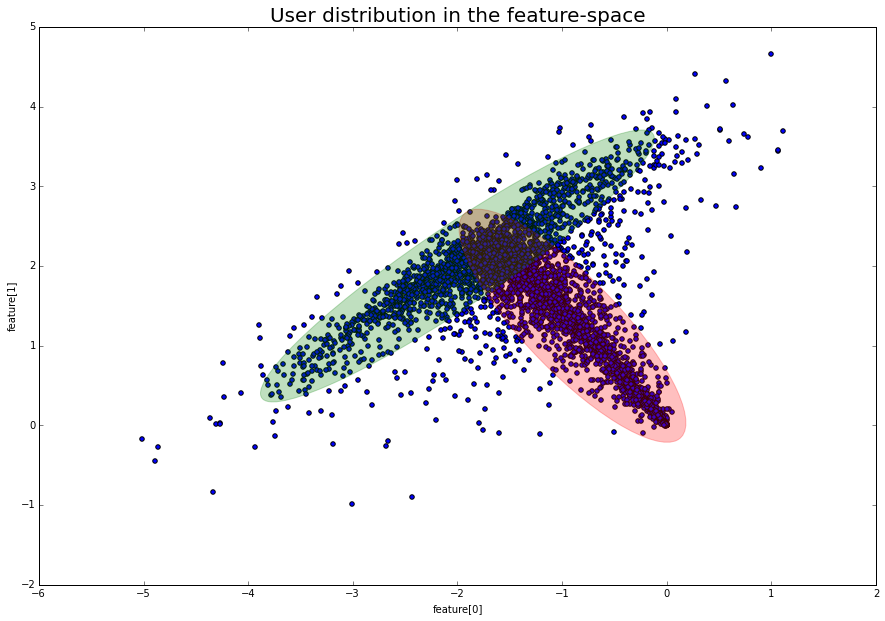

In [57]:
fig = plt.figure(figsize=(15,10), )
ax = fig.add_subplot(111)

ax.scatter(features[0], features[1])
ax.set_xlabel('feature[0]')
ax.set_ylabel('feature[1]')

plt.title('User distribution in the feature-space', fontsize=20)

ell1 = Ellipse(xy=[-0.9,1.25], width=1, height=3.5, angle=35, color='r', alpha=0.25)
ell2 = Ellipse(xy=[-2,2.], width=.90, height=5, angle=132, color='g', alpha=0.25)
ax.add_artist(ell1)
ax.add_artist(ell2)

plt.show()

<font color='blue'>
Visualize the latent space reserves interesting points to discuss. 
<br><br>
Firstly, users reppresented in their feature space are grouped following trends and this is justified by the nature of the problem: it is likely possible that users can have similar tastes are grouped together. It's fair to assume that this algorithm works really well for all those users. 
<br><br>
On the other hand, even though a lot of samples (users) fall in one well-shaped category, there is someone with unique musical tastes difficult to satisfy. Here is where the algorithm is expected to fail.
<br><br>
Outliers, here, are representative of both _curious users_ (those who listen a lot of different artists), which are difficult to categorize, and _new users_, for which the system has not yet collected enough information to learn their preferences. 
</font>

# Appendix 1

## Let's try modify the ratings

<font color='blue'>
Here, our intent is to include some more information on the rating user-artist. For this purpose, we tried to use the data coming from the user activity and the user curiosity, to increase our belief on the preferences of users.
The idea here is to extend the dimensionality of the rating with this extra information, then perform a PCA to go back to one dimension and finally perform the usual ASL. However after some experiments (some of them here below), it seems that after the PCA, we got results that are nearly similar to the original.
</font>

In [108]:
featuresDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("activityRank", FloatType(), True), \
    StructField("curiosityRank", FloatType(), True)])

featureDF = curiousActiveRankDF.select('userID', 'activityRank', 'curiosityRank')
featureDF.show(2)

+-------+------------+-------------+
| userID|activityRank|curiosityRank|
+-------+------------+-------------+
|1000061|      107637|        67154|
|1000070|        1721|        58621|
+-------+------------+-------------+
only showing top 2 rows



In [105]:
maxActivityRank = featureDF.select(max('activityRank')).collect()[0][0]
maxCuriosityRank = featureDF.select(max('curiosityRank')).collect()[0][0]

featureRDD = featureDF.rdd\
    .map(lambda x:\
    (x[0], 1/(1.0+math.exp(-x[1]/maxActivityRank*2)) * 1/(1.0+math.exp((x[2]-maxCuriosityRank)/maxCuriosityRank*2))))

#print(featureRDD.take(4))

[(1000061, 0.6070736107709415), (1000070, 0.38948293635940484), (1000313, 0.4950850824766112), (1000832, 0.5976189173217848)]


In [89]:
featuresDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("activityRank", FloatType(), True), \
    StructField("curiosityRank", FloatType(), True)])
    
featureDF = curiousActiveRankDF.select('userID', 'activityRank', 'curiosityRank')
featureDF.show(5)

featureRDD = featureDF.rdd.map(lambda x:(x[0], 1/(1.0+math.exp(-x[1]/5000)), 1/(1.0+math.exp((x[2]-10000)/5000))))

featureDF = sqlContext.createDataFrame(featureRDD, featuresDataSchema)
featureDF = featureDF.join(userArtistCleanDF, featureDF.userID==userArtistCleanDF.userID).drop(userArtistCleanDF.userID)
featureDF.show()

assembler = VectorAssembler(inputCols=["activityRank", "curiosityRank", "playCount"], outputCol="features")
featureDF = assembler.transform(featureDF).select('userID', 'realArtistID', 'features')
featureDF.show(5, truncate=False)

+-------+------------+-------------+
| userID|activityRank|curiosityRank|
+-------+------------+-------------+
|1000061|      107637|        67154|
|1000070|        1721|        58621|
|1000313|      111351|       116490|
|1000832|       68521|        28283|
|1000905|      110204|       124149|
+-------+------------+-------------+
only showing top 5 rows

+-------+------------+-------------+---------+------------+
| userID|activityRank|curiosityRank|playCount|realArtistID|
+-------+------------+-------------+---------+------------+
|1000061|         1.0| 1.0855802E-5|       16|     1000158|
|1000061|         1.0| 1.0855802E-5|        1|     1000193|
|1000061|         1.0| 1.0855802E-5|        1|     1000451|
|1000061|         1.0| 1.0855802E-5|        1|     1000906|
|1000061|         1.0| 1.0855802E-5|        1|     1001348|
|1000061|         1.0| 1.0855802E-5|        1|     1002036|
|1000061|         1.0| 1.0855802E-5|        7|     1002068|
|1000061|         1.0| 1.0855802E-5|      

In [186]:
PCA_model = PCA(k=1, inputCol='features', outputCol="pca_feature")
model = PCA_model.fit(dataset=featureDF)

PCA_featuresDF = model.transform(featureDF).select('userID', 'realArtistID', 'pca_feature')#.agg(abs('pca_feature'))
PCA_features.show(5, truncate=False)

+-------+--------------------+
|userID |pca_feature         |
+-------+--------------------+
|1000061|[-317.095898605294] |
|1000070|[-22184.44348678223]|
|1000313|[-261.2135488339613]|
|1000832|[-1391.405937867246]|
|1000905|[-278.1079574375401]|
+-------+--------------------+
only showing top 5 rows



# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)